In [1]:
import json
import math
import altair as alt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter 
from dataclasses import dataclass
from typing import Dict, Union, List
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from matplotlib.ticker import FuncFormatter


In [2]:
GROUNDED_LABEL = 0  # 0 for grounded/entailed 
CONTRADICT_LABEL = 2 # 2 for contradiction

## Data Demonstration


In [3]:
file_path = "hallucination_detection_aug01_feb08_clean_doc.jsonl"
with open(file_path, 'r') as fp:
    examples = [
        json.loads(line.strip())
        for line in fp
    ]

In [4]:
# number of responses, and number of truncated docs in total
len(examples), sum(len(exp["documents"]) for exp in examples)

(579, 10207)

In [5]:
# Show the truncated parts of the top 5 retrieved docs for the first response
examples[0]["documents"]

[{'index': 0,
  'title': 'Segment Definition Class | Adobe Experience Platform',
  'content': '“Segment definition” is a standard Experience Data Model (XDM) class that captures the details of a segment definition. The class includes required fields such as the ID and name of an audience, along with other optional attributes. This class should be used if you are bringing in segment definitions from external systems into Adobe Experience Platform.',
  'score': 0.3562326431,
  'url': 'https://experienceleague.adobe.com/docs/experience-platform/xdm/classes/segment-definition.html?lang=en'},
 {'index': 1,
  'title': 'Segment Definitions API Endpoint | Adobe Experience Platform',
  'content': 'Adobe Experience Platform allows you to create segment definitions that define a group of specific attributes or behaviors from a group of profiles. A segment definition is an object that encapsulates a query written in Profile Query Language (PQL). Segment definitions are applied to profiles to creat

In [6]:
# Show the first response 
examples[0]["split_sentences"]

['A segment is a group of customers or users who share similar characteristics, behaviors, or preferences.',
 'Segments can be created based on a variety of data sources, such as demographic information, website interactions, purchase history, and more.',
 'Segments are used to personalize and target marketing campaigns, as well as to gain insights into customer behavior and preferences.',
 'Adobe Experience Platform provides tools to create, manage, and analyze segments, as well as to activate them across various channels and touchpoints.']

In [7]:
# Show the Grounded/Neutral/Conflict scores obtained from NLI for each sentence - truncated doc pair in the first response
raw_table = pd.DataFrame(examples[0]["raw_scores"])
display(raw_table)

,sentence_index,document_index,scores
0,0,0,"[0.12194451689720154, 0.7667281031608582, 0.11..."
1,0,1,"[0.32835090160369873, 0.5959809422492981, 0.07..."
2,0,2,"[0.49650853872299194, 0.3324725031852722, 0.17..."
3,0,3,"[0.051443446427583694, 0.4921155273914337, 0.4..."
4,0,4,"[0.07185587286949158, 0.8413073420524597, 0.08..."
5,0,5,"[0.07621972262859344, 0.7559218406677246, 0.16..."
6,0,6,"[0.076375313103199, 0.8026028871536255, 0.1210..."
7,0,7,"[0.11216443032026291, 0.5069026947021484, 0.38..."
8,0,8,"[0.030852820724248886, 0.8354015946388245, 0.1..."
9,0,9,"[0.3231462836265564, 0.41805198788642883, 0.25..."


## Aggregation Methods

### Method 1: Based on grounded score
Step 1. Sentence-level Score: For each sentence within a response, select the highest **grounded** score from among the segmented parts of the documents. The score attributed to each sentence reflects the most reliable part of the available documents. 

Step 2. Response-level Score: Calculate average above sentence-level scores and obtain response-level score.

Step 3. Threshold-based classification: Employ a predetermined threshold to categorize responses as hallucinated if the response-level score is **less** than the threshold.  

### Method 2: Based on conflict score
Step 1. Sentence-level Score: For each sentence within a response, select the highest **conflict** score from among the segmented parts of the documents. 

Step 2. Response-level Score: Same as above.

Step 3. Threshold-based classification: Employ a predetermined threshold to categorize responses as hallucinated if the cumulative score is **larger** than the threshold.  

### Method 3: Based on grounded label

Step 1. For each sentence in a response, identify the document segment that has the highest **grounded** score among all segmented parts.

Step 2. Label each sentence as grounded/neutral/conflict, depending on which score (grounded/neutral/conflict) is highest in the document segment identified in Step 1.

Step 3. Calculate the response-level score as the proportion of sentences which are labeled as **grounded**.

Step 4. Utilize a predetermined threshold to classify entire responses as hallucinated if the response-level score is **less** than the threshold.

### Method 4: Based on conflict label

Step 1. For each sentence in a response, identify the document segment that has the highest **conflict** score among all segmented parts.

Step 2. Same as above.

Step 3. Calculate the response-level score as the proportion of sentences which are labeled as **conflict**.

Step 4. Utilize a predetermined threshold to classify entire responses as hallucinated if the response-level score is **larger** than the threshold.

In [8]:
def doc_agg_max(doc_scores: List[Dict[str, Union[int, float]]], **kwargs):
    best_doc_score = max(doc_scores, key=lambda x: x["scores"][GROUNDED_LABEL])
    return best_doc_score

def doc_agg_min(doc_scores: List[Dict[str, Union[int, float]]], **kwargs):
    worst_doc_score = max(doc_scores, key=lambda x: x["scores"][CONTRADICT_LABEL])
    return worst_doc_score

def sent_agg_mean(sents: List[float]):
    return sum(sents) / len(sents)

def aggregate(scores: List[Dict[str, Union[int, float]]]):
    grouped_by_sent = [[] for _ in range(max(grd["sentence_index"] for grd in scores) + 1)]
    # grd["sentence_index"] will return sentence index for the response
    # i-th element in grouped_by_sent is the score of i-th sentence to all doc segments
    for grd in scores:
        grouped_by_sent[grd["sentence_index"]].append(grd)

    # a. Aggregation based on scores (Method 1 and 2)
    
    # best_doc_for_sents has the same length as grouped_by_sent. It extracts the doc with maximum grounded score
    best_doc_for_sents = [
        doc_agg_max(doc_scores)
        for doc_scores in grouped_by_sent
    ]

    # worst_doc_for_sents extracts the doc with maximum conflict score
    worst_doc_for_sents = [
        doc_agg_min(doc_scores)
        for doc_scores in grouped_by_sent
    ]

    # Final aggregated score for Method 1 and 2
    final_score_grounded = sent_agg_mean([d["scores"][GROUNDED_LABEL] for d in best_doc_for_sents])
    final_score_contradict = sent_agg_mean([d["scores"][CONTRADICT_LABEL] for d in worst_doc_for_sents])


    # b. Aggregation based on labels (Method 3 and 4)

    # Assign labels for each sentence
    sentence_labels_grounded = []
    for best_doc in best_doc_for_sents:
        highest_score_index = best_doc['scores'].index(max(best_doc['scores']))  # Get index of the highest score
        sentence_labels_grounded.append(highest_score_index)
    
    sentence_labels_conflict = []
    for worst_doc in worst_doc_for_sents:
        highest_score_index = worst_doc['scores'].index(max(worst_doc['scores']))  # Get index of the highest score
        sentence_labels_conflict.append(highest_score_index)
    
    # Final aggregated score for Method 3 and 4
    grounded_proportion = sentence_labels_grounded.count(GROUNDED_LABEL) / len(sentence_labels_grounded) if sentence_labels_grounded else 0
    contradict_proportion = sentence_labels_conflict.count(CONTRADICT_LABEL) / len(sentence_labels_conflict) if sentence_labels_conflict else 0


    return final_score_grounded, [d["document_index"] for d in best_doc_for_sents], final_score_contradict, [d["document_index"] for d in worst_doc_for_sents], sentence_labels_grounded, grounded_proportion, sentence_labels_conflict, contradict_proportion

In [9]:
for exp in examples:
    final_score_grounded, best_docs, final_score_contradict, worst_docs, sentence_labels_grounded, grounded_proportion, sentence_labels_conflict, contradict_proportion = aggregate(exp["raw_scores"])
    exp["groundness_score"] = final_score_grounded
    exp["best_docs"] = best_docs
    exp["contradict_score"] = final_score_contradict
    exp["worst_docs"] = worst_docs
    exp["sentence_labels_grounded"] = sentence_labels_grounded
    exp["sentence_labels_conflict"] = sentence_labels_conflict
    exp["ground_proportion"] = grounded_proportion
    exp["contradict_proportion"] = contradict_proportion


In [10]:
list_df = pd.DataFrame(examples)
display(list_df.head())


,id,createddate,chatid,imsorgid,createdby,sandboxid,customer_name,chat_index,query,rewritten_query,...,split_sentences,raw_scores,groundness_score,best_docs,contradict_score,worst_docs,sentence_labels_grounded,sentence_labels_conflict,ground_proportion,contradict_proportion
0,83b782d2-3d5e-48b1-86da-e45b70aadc8d,1693592450269000000,b2ae7f01-023f-4eea-a9a8-6e9c68c0b0f4,757A02BE532B22BA0A490D4C@AdobeOrg,AFB61DB364F1F2210A495C15@84251f4c631c16d9495e59.e,3f794bd0-a94d-46c8-b94b-d0a94d46c806,GM,5,What is a segment?,RewriteNotEnabled,...,[A segment is a group of customers or users wh...,"[{'sentence_index': 0, 'document_index': 0, 's...",0.367737,"[11, 9, 9, 11]",0.147236,"[3, 3, 9, 5]","[0, 1, 1, 1]","[1, 1, 1, 1]",0.250000,0.000000
1,5b86aabf-de84-4acf-8a28-944ec835938b,1693592462384000000,b2ae7f01-023f-4eea-a9a8-6e9c68c0b0f4,757A02BE532B22BA0A490D4C@AdobeOrg,AFB61DB364F1F2210A495C15@84251f4c631c16d9495e59.e,3f794bd0-a94d-46c8-b94b-d0a94d46c806,GM,5,What is an audience?,RewriteNotEnabled,...,[An audience is a collection of people who sha...,"[{'sentence_index': 0, 'document_index': 0, 's...",0.670873,"[4, 4, 2, 1]",0.078344,"[2, 3, 1, 3]","[0, 0, 1, 1]","[0, 1, 1, 1]",0.500000,0.000000
2,be62ccfa-d8ed-4895-a86d-66320dae8a31,1693596395751000000,b2ae7f01-023f-4eea-a9a8-6e9c68c0b0f4,757A02BE532B22BA0A490D4C@AdobeOrg,AFB61DB364F1F2210A495C15@84251f4c631c16d9495e59.e,3f794bd0-a94d-46c8-b94b-d0a94d46c806,GM,5,What are the differences between batch and str...,RewriteNotEnabled,...,[Batch ingestion allows you to ingest data int...,"[{'sentence_index': 0, 'document_index': 0, 's...",0.975360,"[0, 0, 0, 0, 1, 1, 1, 3, 3]",0.069768,"[1, 4, 3, 4, 0, 3, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 1, 1, 1, 1, 1, 1]",1.000000,0.000000
3,f5b2ba11-113d-46b3-9758-5203ef079fcb,1693596424510000000,b2ae7f01-023f-4eea-a9a8-6e9c68c0b0f4,757A02BE532B22BA0A490D4C@AdobeOrg,AFB61DB364F1F2210A495C15@84251f4c631c16d9495e59.e,3f794bd0-a94d-46c8-b94b-d0a94d46c806,GM,5,what is a schem?,RewriteNotEnabled,...,[A schema is a format and structure of data th...,"[{'sentence_index': 0, 'document_index': 0, 's...",0.778823,"[0, 0, 0, 0, 4, 1]",0.223411,"[5, 4, 4, 3, 1, 3]","[0, 0, 0, 0, 0, 1]","[1, 1, 1, 1, 2, 1]",0.833333,0.166667
4,88054216-9e16-4334-afe7-e1d455799df8,1693927457524000000,6db0369e-c145-4a90-856c-a39a7ac59c83,9E1005A551ED61CA0A490D45@AdobeOrg,8BC01F61631C79440A495CEE@86071f62631c0cc0495e71.e,8bc84805-19f3-4f0d-8848-0519f3ff0d66,Adobe.com,6,what is a segment?,RewriteNotEnabled,...,[A segment is a group of customers or users wh...,"[{'sentence_index': 0, 'document_index': 0, 's...",0.259271,"[11, 9, 9, 9, 7, 7, 11]",0.301970,"[3, 3, 9, 8, 7, 8, 5]","[0, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 2, 1, 1, 1]",0.142857,0.142857


## Assign True Label for Hallcination

In [11]:
# 0: non-hallucinated
# 1: hallucinated

label_mapping = {
    "Concept_Correct": 0,
    "Concept_Partially_Correct": 1,
    "Concept_Incorrect": 1,
    "Concept_IrrelevantAnswer": 1,
#     "Concept_Correct_Unable_To_Answer": 0,
    "Concept_Correct_Hallucination": 0,
    "Concept_QueryRewriteError": 1,
    "Concept_Ambiguous": 1,
    "Concept_Correct_Routing_OOS": 0,
    "Concept_Ambiguous_HelpfulAnswer": 0,
    "Concept_Ambiguous_DidNotAnswer": 0    
}
annotated_examples = [
    exp
    for exp in examples
    if isinstance(exp["concept_primary_error"], str) and exp["concept_primary_error"] in label_mapping
]


keyword = 'hallu'
exclude_link = {"Concept_PoorRetrieval_CouldNotProvideLInk_HallucinatedLink"}
for example in annotated_examples:
    detailed_error_lower = example["concept_detailed_error"].lower()
    primary_error_lower = example["concept_primary_error"].lower()
    
    if ((keyword in detailed_error_lower or keyword in primary_error_lower) and
        example["concept_detailed_error"] not in exclude_link):
        example['has_hallucination'] = 1
    else:
        example['has_hallucination'] = 0

Counter(pd.DataFrame(annotated_examples)["has_hallucination"])


Counter({0: 92, 1: 27})

In [12]:
display(pd.DataFrame(annotated_examples).head())

,id,createddate,chatid,imsorgid,createdby,sandboxid,customer_name,chat_index,query,rewritten_query,...,raw_scores,groundness_score,best_docs,contradict_score,worst_docs,sentence_labels_grounded,sentence_labels_conflict,ground_proportion,contradict_proportion,has_hallucination
0,f1f461b6-d2f8-4e1d-81ab-471fb302b176,1704806019681000000,a8bf8cd3-6a31-4b05-ae4e-c822f5d1ef50,F0935E09512D2C270A490D4D@AdobeOrg,E4D8205A6363BA360A495F95@6c265fe4634c825a495c69.e,2a698b26-9a59-4782-a98b-269a59f782c6,Nike,357,I want to know the profiles against each sche...,I want to see the profiles associated with eac...,...,"[{'sentence_index': 0, 'document_index': 0, 's...",0.387498,"[3, 3, 3, 3, 3, 0, 3, 0]",0.626478,"[4, 5, 5, 5, 5, 5, 5, 2]","[0, 0, 0, 0, 1, 1, 1, 1]","[1, 2, 2, 2, 2, 2, 2, 1]",0.500000,0.750000,1
1,cc87af67-881b-453a-bcb5-795fd7f49570,1704806140947000000,a8bf8cd3-6a31-4b05-ae4e-c822f5d1ef50,F0935E09512D2C270A490D4D@AdobeOrg,E4D8205A6363BA360A495F95@6c265fe4634c825a495c69.e,2a698b26-9a59-4782-a98b-269a59f782c6,Nike,357,I want to know the profiles against each schem...,I want to see the profiles associated with eac...,...,"[{'sentence_index': 0, 'document_index': 0, 's...",0.387498,"[3, 3, 3, 3, 3, 0, 3, 0]",0.626478,"[4, 5, 5, 5, 5, 5, 5, 2]","[0, 0, 0, 0, 1, 1, 1, 1]","[1, 2, 2, 2, 2, 2, 2, 1]",0.500000,0.750000,1
2,77f140bd-79d9-483b-9424-b4fd29564b6b,1704910846706000000,038870eb-dacb-462d-9745-5e20a70f4499,969430F0543F253D0A4C98C6@AdobeOrg,56C92D2563DC95CF0A495F9F@55ad264263dc8855495ce4.e,9fa3aa1d-f7e3-4422-a3aa-1df7e38422d4,Intuit,358,How many audiences can be created per instance?,How many audiences can be created per instance?,...,"[{'sentence_index': 0, 'document_index': 0, 's...",0.674522,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.441857,"[4, 4, 1, 5, 1, 5, 1, 5, 1, 5, 4, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, ...","[1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 1, 0, 1, 1, ...",0.705882,0.411765,0
3,57dccfc6-f67d-4b8c-9cdf-d13fd45ef1da,1704919856058000000,0f3ecc3f-f87e-4b2b-a3f5-1004abab236a,675616D751E567410A490D4C@AdobeOrg,38DC59425F2C00630A495EC6@68d058ac5bcdfc160a495cda,ae06b6a0-34f4-4e16-86b6-a034f4ae16ca,US_Bank,359,how do I setup the AAM destination in AEP?,how do I setup the AAM destination in AEP?,...,"[{'sentence_index': 0, 'document_index': 0, 's...",0.478825,"[2, 2, 2, 5, 5, 5, 2, 2, 2, 2, 2]",0.406426,"[4, 0, 3, 3, 4, 4, 4, 2, 2, 4, 4]","[0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0]","[2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2]",0.454545,0.545455,1
4,dc63ca85-7a3a-46b8-b9cf-d8024e5414ba,1704979363919000000,2209723c-5b1f-47e5-8171-d2731ea1323d,757A02BE532B22BA0A490D4C@AdobeOrg,0C811E0C64C2CC060A495CD0@84251f4c631c16d9495e59.e,fd0f3003-202d-421c-8f30-03202d121cdf,GM,360,Tell me some common use cases for Real-Time CDP.,Tell me some common use cases for Real-Time CDP.,...,"[{'sentence_index': 0, 'document_index': 0, 's...",0.320110,"[23, 11, 22, 11, 13, 11, 11, 10, 0, 8, 2, 9, 2]",0.558750,"[2, 2, 2, 1, 17, 1, 2, 1, 2, 2, 2, 1, 2]","[0, 1, 1, 0, 1, 0, 0, 2, 1, 2, 2, 1, 1]","[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1]",0.307692,0.538462,0


## Evaluation via Threshold Study

In [13]:
def calculate_metrics_from_pairs(pair):
    actual_bad = [p for p in pair if p[1] == 1]
    # actual_good = [p for p in pair if p[1] == 0]
    predicted_bad = [p for p in pair if p[0] == 1]
    # predicted_good = [p for p in pair if p[0] == 0]

    true_positive = len([p for p in actual_bad if p[0] == 1])
    # false_positive = len([p for p in actual_good if p[0] == 1])
    # false_negative = len([p for p in actual_bad if p[0] == 0])
    # true_negative = len([p for p in actual_good if p[0] == 0])

    recall = true_positive / len(actual_bad) if len(actual_bad) > 0 else 0
    precision = true_positive / len(predicted_bad) if len(predicted_bad) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return recall, precision, f1


def get_scores_labels(annotated_examples, method):
    y_scores = []
    y_true = []
    for exp in annotated_examples:
        ## Skip examples not in label_mapping
        # if exp["concept_primary_error"] not in label_mapping:
        #     continue  

        # Select the evaluation method based on 'method' parameter
        if method == 'ground_score':
            adjust_score = 1 - exp["groundness_score"]
        elif method == 'contradict_score':
            adjust_score = exp["contradict_score"]
        elif method == 'ground_proportion':
            adjust_score = 1 - exp["ground_proportion"]
        elif method == 'contradict_proportion':
            adjust_score = exp["contradict_proportion"]

        y_scores.append(adjust_score)
        y_true.append(exp["has_hallucination"])
    
    return y_scores, y_true


def evaluate_method(annotated_examples, method, thresholds):
    eval_df = []
    # Obtain y_scores and y_true
    y_scores, y_true = get_scores_labels(annotated_examples, method)
    
    y_scores_y_true_df = pd.DataFrame({
        'Method': [method] * len(y_scores),
        'Y_Score': y_scores,
        'Y_True': y_true
    })

    for t in thresholds:
        pairs = []
        for index, score in enumerate(y_scores):
            # Determine predicted_label based on score and threshold
            if method in ['ground_score', 'ground_proportion']:
                predicted_label = 1 if score >= t else 0
            else:  # 'contradict_score', 'contradict_proportion'
                predicted_label = 1 if score <= t else 0

            pairs.append((predicted_label, y_true[index]))

        r, p, f1 = calculate_metrics_from_pairs(pairs)
        false_positives = [i for i, (pred, actual) in enumerate(pairs) if pred == 1 and actual == 0]
        false_negatives = [i for i, (pred, actual) in enumerate(pairs) if pred == 0 and actual == 1]

        eval_df.append({
            'Method': method,
            'Threshold': t,
            'Recall': r,
            'Precision': p,
            'F1 Score': f1,
            'False Positives': false_positives,
            'False Negatives': false_negatives
        })
    
    return pd.DataFrame(eval_df), y_scores_y_true_df

In [14]:
num_thrsholds = 100
thresholds = [
    i * 1/num_thrsholds for i in range(num_thrsholds)
]
methods = ['ground_score', 'contradict_score', 'ground_proportion', 'contradict_proportion']
all_evaluations = []
y_data_frames = []

for method in methods:
    eval_df, y_scores_y_true_df_method = evaluate_method(annotated_examples, method, thresholds)
    all_evaluations.append(eval_df)
    y_data_frames.append(y_scores_y_true_df_method)


all_evaluations_df = pd.concat(all_evaluations, ignore_index=True)
y_scores_y_true_df = pd.concat(y_data_frames, ignore_index=True)

## Visualization

In [15]:
# Function to plot ROC Curve and calculate AUC
def plot_roc_and_calculate_auc(y_true, y_scores):
    # Calculate AUC using sklearn's roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plotting ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall Curve and Calculate AU-PRC
def plot_precision_recall(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    area = auc(recall, precision)

    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (area = {area:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision vs Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot Precision/Recall/F1 score across different thresholds
def plot_evaluation_metrics_altair(best_method_data_metric):
    df = pd.DataFrame({
        "Metric Value": best_method_data_metric["Recall"].tolist() + best_method_data_metric["Precision"].tolist() + best_method_data_metric["F1 Score"].tolist(),
        "Threshold": list(best_method_data_metric["Threshold"]) * 3,
        "Metric": ["Recall" for _ in best_method_data_metric["Threshold"]] + ["Precision" for _ in best_method_data_metric["Threshold"]] + ["F1 Score" for _ in best_method_data_metric["Threshold"]]
    })

    chart = alt.Chart(df).mark_line().encode(
        x=alt.X('Threshold:Q', title='Threshold'),
        y=alt.Y('Metric Value:Q', title='Metric Value'),
        color=alt.Color('Metric:N', title='Metric Type'),
        tooltip=['Threshold', 'Metric Value', 'Metric']
    ).properties(
        width=600,
        height=400,
        title='Evaluation Metrics Across Thresholds'
    ).interactive()

    return chart

## Select the Best Method based on Optimal F1 Score

In [16]:
best_f1_per_method = all_evaluations_df.loc[all_evaluations_df.groupby('Method')['F1 Score'].idxmax()]
display(best_f1_per_method)

,Method,Threshold,Recall,Precision,F1 Score,False Positives,False Negatives
392,contradict_proportion,0.92,0.962963,0.238532,0.382353,"[2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, ...",[112]
181,contradict_score,0.81,0.925926,0.260417,0.406504,"[2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, ...","[13, 112]"
276,ground_proportion,0.76,0.555556,0.500000,0.526316,"[8, 10, 19, 24, 25, 27, 29, 34, 48, 51, 52, 80...","[0, 1, 3, 13, 16, 31, 37, 46, 54, 88, 94, 115]"
50,ground_score,0.50,0.888889,0.393443,0.545455,"[4, 5, 8, 10, 14, 19, 22, 24, 25, 27, 29, 30, ...","[16, 31, 94]"


In [17]:
best_method_row = best_f1_per_method.nlargest(1, 'F1 Score')
best_method = best_method_row['Method'].values[0]
display(best_method_row)

# Extracting y_scores and y_true for the best method from y_scores_y_true_df
best_method_y_scores_y_true = y_scores_y_true_df[y_scores_y_true_df['Method'] == best_method]
y_scores = best_method_y_scores_y_true['Y_Score'].tolist()
y_true = best_method_y_scores_y_true['Y_True'].tolist()

# Extracting other eval metrics for the best method from all_evaluations_df
best_method_data_metric = all_evaluations_df[all_evaluations_df['Method'] == best_method]


,Method,Threshold,Recall,Precision,F1 Score,False Positives,False Negatives
50,ground_score,0.5,0.888889,0.393443,0.545455,"[4, 5, 8, 10, 14, 19, 22, 24, 25, 27, 29, 30, ...","[16, 31, 94]"


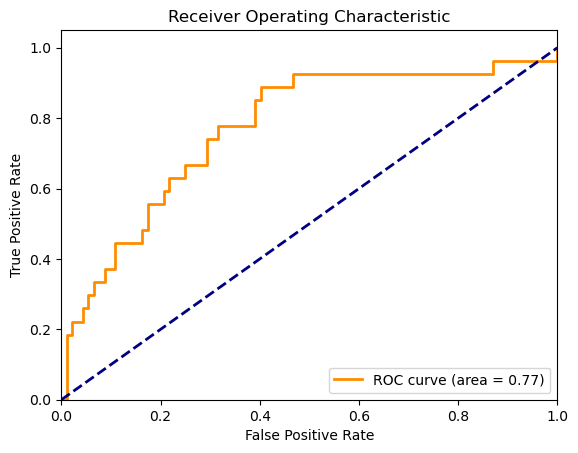

In [18]:
# Plot ROC Curve for the best method
plot_roc_and_calculate_auc(y_true, y_scores)

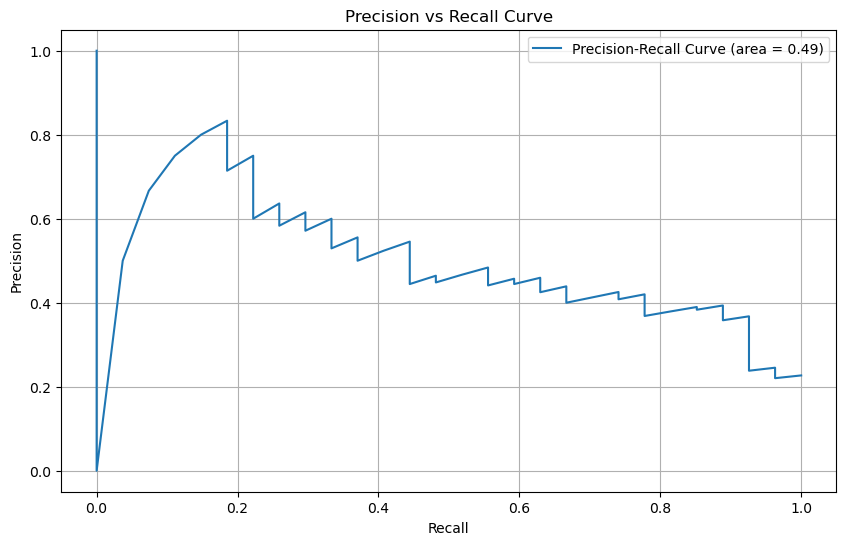

In [19]:
# Plot AU-PRC Curve for the best method
plot_precision_recall(y_true, y_scores)

In [20]:
# Plot Recall/Precision/F1 Score across different thresholds for the best method 
chart = plot_evaluation_metrics_altair(best_method_data_metric)
chart.display()

alt.Chart(...)

## Save False Positive/Negative Examples Deep Analysis

In [21]:
def save_fp_fn_analysis_to_excel(best_method_row, annotated_examples):
    """
    Extracts and analyzes False Positives and False Negatives from annotated_examples
    based on indices provided in best_method_row.
    
    Returns:
    - DataFrame of extracted data.
    """
    
    # Extract False Positives and False Negatives indices directly
    best_method_row = best_method_row.iloc[0]
    best_fp_indices = best_method_row['False Positives']
    best_fn_indices = best_method_row['False Negatives']

    extracted_data = []

    # Extract data for False Positives
    for idx in best_fp_indices:
        data_row = annotated_examples[idx]
        data_row['Type'] = 'False Positive'
        extracted_data.append(data_row)

    # Extract data for False Negatives
    for idx in best_fn_indices:
        data_row = annotated_examples[idx]
        data_row['Type'] = 'False Negative'
        extracted_data.append(data_row)

    # Create a DataFrame from the extracted data
    df_extracted = pd.DataFrame(extracted_data)

    return df_extracted

In [22]:
df_extracted = save_fp_fn_analysis_to_excel(best_method_row, annotated_examples)
df_extracted.to_excel('best_row_analysis_label_clean_doc.xlsx', index=False, engine='openpyxl')